## Modeling Prostate Cancer Progression

In [1]:
import pandas as pd
import numpy as np
import math


from math import *
import matplotlib.pyplot as plt
from functools import reduce
from datetime import datetime
from tqdm import tqdm

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.impute import SimpleImputer
import random
import seaborn as sns

import optuna
from optuna.integration import XGBoostPruningCallback

import re

# Utils

We keep track of all the functions used later in this notebook

In [3]:
''' We use this function to only keep the patients that have more than l PSA values (e.g. if we want to use 
3 past PSA values to predict the 4th, we need to keep patients that have 4 or more recorded PSA values '''

def filter_length(df, l):
    return df.groupby('EMPI').filter(lambda x : len(x)>l)

In [4]:
''' Given our lab values dataset and a sequence length, we define a function that allows us to extract the 
PSA sequences as rows along with the rest of the useful corresponding data (BMI, MRI, race, comorbidity scores, etc)
using the sliding window method explained in our report '''

def window(df, l, rate=True, report=True, comorb=True, race=True):
    
    df_x = pd.DataFrame()
    Y = []
    
    idx_comorb = df.columns.get_loc("mi_agg")
    comorb_names = df.columns[idx_comorb::]
        
    race_names = ["Asian", "Black", "Hispanic", "Unknown/other", "White"]
    
    iterator = 0
    
    for patient_id in df.EMPI.unique():

        subset = df[df["EMPI"]==patient_id].sort_values(by=["delta"])
        psa_seq = subset.PSA
        delta_seq = subset.delta
        
        for i in range(l-1,len(subset)-1):
            
            X = []
            Y.append(psa_seq.iloc[i+1])
            
            X.append(patient_id)
            
            for j in range(i-(l-1),i+1):
                
                if rate == True:
                    
                    if j ==(i-(l-1)):
                        X.append(psa_seq.iloc[j])
                    else:
                        if (delta_seq.iloc[j]-delta_seq.iloc[j-i]) > 0:
                            X.append((psa_seq.iloc[j]-psa_seq.iloc[j-1])/(delta_seq.iloc[j]-delta_seq.iloc[j-i]))
                        else:
                            X.append((psa_seq.iloc[j]-psa_seq.iloc[j-1]))
                    
    
                    
                else:
                    
                    X.append(psa_seq.iloc[j])
                    X.append(delta_seq.iloc[j])
                    
                X.append(subset["bmi"].iloc[j])
                
            X.append(delta_seq.iloc[i+1])    
            X.append(subset["age_diagnosis"].iloc[i+1])
            
            if race:
                
                for race in race_names:
                    X.append(subset[race].iloc[i])
            
            if comorb:

                for comor in comorb_names:
                    X.append(subset[comor].iloc[i])
            
            #X.append(subset["race_cat"].iloc[i])
            
            if report:
                X.append(subset["report"].iloc[i])
            
            df_x[iterator] = X
            
            iterator += 1

    return df_x.T, Y

In [5]:
''' We use the previously defined functions to split our dataset into train and test '''

def random_split(df, split_ratio, l=3, seed=10, rate=True, report=True, comorb=True, race=True):
    
    permutation = np.random.RandomState(seed=seed).permutation(merged['EMPI'].unique())
    training_idx, test_idx = permutation[:floor(split_ratio*len(permutation))], permutation[floor(split_ratio*len(permutation)):]

    X_train, y_train = window(df[df['EMPI'].isin(training_idx)], l, rate=rate, report=report, comorb=comorb, race=race)
    X_test, y_test = window(df[df['EMPI'].isin(test_idx)], l, rate=rate, report=report, comorb=comorb, race=race)
    
    return X_train, y_train, X_test, y_test

In [6]:
''' We define a vocabulary and use it to clean our MRI reports in order to run a meaningful Bag of Words'''

def get_notes(pat):
    corpus = []
    for idx in pat.index:
        
        note = pat.loc[idx][len(pat.columns) - 1]
        note = re.sub(r'[0-9]+', '', note)
        note = note.replace("\n", '')
        note = note.replace("\r", '')
        note = note.replace("Exam Number:", "")
        note = note.replace("Report Status:  FinalType:  MRIProstateWWODate/Time:  // :Exam Code:  MRIPROWWOOrdering Provider: ", "")
        note = note.replace("[report_end", "")
        note = note.replace("/", "")
        note = note.strip()
        corpus.append(note)
    return corpus

# Data preprocessing

## Importing the data

In [20]:
''' All of our features are split into different files that we all need to import '''

active = pd.read_csv("Processed data/actsurv_EMPI.csv")
lab = pd.read_csv("Processed data/labs_cl.csv")
radiation = pd.read_csv("Processed data/first_date_radiationtx.csv")
proton = pd.read_csv("Processed data/first_date_proton.csv")
surgery = pd.read_csv("Processed data/multirp.csv")
surgery_single = pd.read_csv("Processed data/singlerp.csv")
race = pd.read_csv("Processed data/race.csv")
age = pd.read_csv("Processed data/birthdeath.csv")
bmi = pd.read_csv("Processed data/bmi.csv")
mri = pd.read_csv("Processed data/mriprostate.csv")
comorb = pd.read_csv("Processed data/comorb_activ.csv")
comorb[['EMPI', 'date']] = comorb['EMPI_day'].str.split(' ', 1, expand=True)
comorb[comorb.columns[23:-1]] = comorb[comorb.columns[23:-1]].astype(int)
comorb['EMPI'] = comorb['EMPI'].astype(int)
reports1 = pd.read_csv('Processed data/KS185_20200918_114153_Rad.txt', sep="|", lineterminator="]")
reports2 = pd.read_csv('Processed data/Sec_KS185_20200918_114153_Rad.txt', sep="|", lineterminator="]")
reports3 = pd.read_csv('Processed data/Third_KS185_20200918_114153_Rad.txt', sep="|", lineterminator="]")
reports4 = pd.read_csv('Processed data/Fourth_KS185_20200918_114153_Rad.txt', sep="|", lineterminator="]")
reports = pd.concat([reports1, reports2, reports3, reports4])
reports['EMPI'] = reports['EMPI'].str.replace("\r\n", "")
reports = reports.rename(columns={"Report_Number": "Accession_Number"})

mri_merged = pd.merge(mri[["Accession_Number"]], reports, on="Accession_Number", how="inner")
mri_merged['Report_Date_Time'] = pd.to_datetime(mri_merged['Report_Date_Time'])
mri_merged.EMPI = mri_merged.EMPI.astype(int)

## Merging useful features

In [21]:
active = pd.merge(active, lab, on="EMPI")

to_merge = [active, radiation[['EMPI', 'rdtdate_first']], proton[['EMPI', 'first_date_proton']], 
      surgery[['EMPI', 'prdate_parsed']],surgery_single[['EMPI', 'date_rp']], age[['EMPI', 'birth_date_parsed']],
           race]

merged = reduce(lambda  left,right: pd.merge(left,right, on=["EMPI"],
                                            how="left"), to_merge)

## Datetime transformations

In [22]:
end = pd.to_datetime('2040-12-15')

col_date = ['rdtdate_first', 'first_date_proton', 'prdate_parsed', 'date_rp', 'time_lab_result',
            'date_firstcancerbx', 'birth_date_parsed']

fillna_date = ['rdtdate_first', 'first_date_proton', 'prdate_parsed', 'date_rp']

merged[col_date] = merged[col_date].apply(pd.to_datetime)
merged[fillna_date] = merged[fillna_date].fillna(end)

bmi.diadate_parsed = pd.to_datetime(bmi.diadate_parsed)
comorb.date = pd.to_datetime(comorb.date)

## Rows selection

Here, we define the end of our PSA sequences using our 2 rules: patient started treatment (radiation or surgery) or patient PSA value suddenly drop to 0, indicating surgery occured. We need to do this because sometimes, patients can get surgery outside of the MGB network, thus it is not recorded in our dataset.

In [23]:
''' Here, for each patient, we try to find a sudden drop of the PSA to 0, indicating surgery. If this happened,
we record the date and we will drop all of the subsequent PSA values. '''

drop_date = []
empi_idx = np.unique(merged.EMPI)

for i in tqdm(np.unique(merged.EMPI), colour="green"):
    
    drop_date.append(min(merged[(merged['EMPI'] == i) & (merged['PSA'] < 0.01)]['time_lab_result'], default=end))
    
d = {'EMPI': empi_idx, 'drop_date': drop_date}
drop_date = pd.DataFrame(data = d)

merged = pd.merge(merged, drop_date, on="EMPI", how="left")

100%|█████████████████████████████████████| 1606/1606 [00:00<00:00, 3655.40it/s]


In [19]:
merged

,EMPI,date_firstcancerbx,date_mostrecentbx,time_lab_result,lab_group,PSA,undetect,greater,Percent Free,Total PSA,...,rdtdate_first,first_date_proton,prdate_parsed,date_rp,birth_date_parsed,race_cat,drop_date_x,age_diagnosis,delta,drop_date_y
0,100002082,2007-09-12,2011-11-02,2017-06-08 09:43:00,PSA (Total and Screening),16.35,False,False,False,True,...,2040-12-15,2040-12-15,2040-12-15,2040-12-15,1938-02-17,Black,2040-12-15,69,117,2040-12-15
1,100002082,2007-09-12,2011-11-02,2016-12-08 09:34:00,PSA (Total and Screening),16.88,False,False,False,True,...,2040-12-15,2040-12-15,2040-12-15,2040-12-15,1938-02-17,Black,2040-12-15,69,111,2040-12-15
2,100002082,2007-09-12,2011-11-02,2016-05-12 09:53:00,PSA (Total and Screening),17.80,False,False,False,True,...,2040-12-15,2040-12-15,2040-12-15,2040-12-15,1938-02-17,Black,2040-12-15,69,104,2040-12-15
3,100002082,2007-09-12,2011-11-02,2016-05-10 09:14:00,PSA (Total and Screening),19.01,False,False,False,True,...,2040-12-15,2040-12-15,2040-12-15,2040-12-15,1938-02-17,Black,2040-12-15,69,104,2040-12-15
4,100002082,2007-09-12,2011-11-02,2015-10-29 10:27:00,PSA (Total and Screening),12.89,False,False,False,True,...,2040-12-15,2040-12-15,2040-12-15,2040-12-15,1938-02-17,Black,2040-12-15,69,97,2040-12-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18186,114901574,2013-03-05,2017-12-19,2018-11-07 11:12:00,PSA Monitoring,13.18,False,False,False,True,...,2040-12-15,2040-12-15,2040-12-15,2040-12-15,1945-05-10,White,2040-12-15,68,68,2040-12-15
18187,114901574,2013-03-05,2017-12-19,2017-11-02 10:11:00,PSA Monitoring,10.32,False,False,False,True,...,2040-12-15,2040-12-15,2040-12-15,2040-12-15,1945-05-10,White,2040-12-15,68,56,2040-12-15
18188,114901574,2013-03-05,2017-12-19,2017-11-02 08:16:00,PSA Monitoring,10.39,False,False,False,True,...,2040-12-15,2040-12-15,2040-12-15,2040-12-15,1945-05-10,White,2040-12-15,68,56,2040-12-15
18189,114901574,2013-03-05,2017-12-19,2013-10-22 10:21:00,PSA Monitoring,7.48,False,False,False,True,...,2040-12-15,2040-12-15,2040-12-15,2040-12-15,1945-05-10,White,2040-12-15,68,7,2040-12-15


In [43]:
''' For each patient, drop all the PSA values after surgery, radiation, or drop of PSA values to < 0.01. '''

merged = merged[merged["Total PSA"] == True]

merged = merged.dropna(subset=['time_lab_result'])
merged = merged[(merged.time_lab_result < merged.rdtdate_first) & 
                (merged.time_lab_result < merged.first_date_proton) & 
                (merged.time_lab_result < merged.prdate_parsed) & 
                (merged.time_lab_result < merged.date_rp) &
                (merged.time_lab_result < merged.drop_date)]

merged = merged.dropna(subset=['PSA'])

## Supplementary features

For our time varying features (BMIs, comorbidities and MRIs), we select the closest recorded feature to the lab value.

In [12]:
bmi_col = np.zeros(len(merged))
report_text = []
comorb_columns = comorb.columns[23:-1]
                      
features_comorb = len(comorb.columns[23:-1])
comorb_features = np.zeros((len(merged), features_comorb))

for i in tqdm(range(len(merged)), colour="green"):
    
    date = merged.iloc[i]['time_lab_result']
    empi = merged.iloc[i]['EMPI']
    
    ### For each line of the data, we find the closest dates of BMI, comorbidities and MRI measurements
    min_bmi = min(bmi[bmi['EMPI']==empi]['diadate_parsed'], key=lambda sub: abs(sub - date), default=0)
    min_comorb = min(comorb[comorb['EMPI']==empi]['date'], key=lambda sub: abs(sub - date), default=0)
    min_report = min(mri_merged[mri_merged['EMPI']==empi]['Report_Date_Time'], key=lambda sub: abs(sub - date), default=0)
    
    ### Extract the closest measurement, or append with 0 if there's no recorded measurement
    
    if (min_bmi != 0):
        bmi_col[i] = bmi[(bmi['EMPI'] == empi) & (bmi['diadate_parsed'] == min_bmi)]['BMI'].iloc[0]
    else:
        bmi_col[i] = 0
                      
    if (min_comorb != 0):
        comorb_features[i] = comorb[(comorb['EMPI'] == empi) & (comorb['date'] == min_comorb)][comorb_columns].iloc[0]
    else:
        comorb_features[i] = np.zeros(comorb_features)
    
    if (min_report != 0):
        report_text.append(str(mri_merged[(mri_merged['EMPI'] == empi) & (mri_merged['Report_Date_Time'] == min_report)]['Report_Text'].iloc[0]))
    else:
        report_text.append("0")

100%|████████████████████████████████████| 18191/18191 [01:47<00:00, 169.09it/s]


In [44]:
''' Adding the resulting columns to our df '''

merged["age_diagnosis"] = merged.date_firstcancerbx.dt.year - merged.birth_date_parsed.dt.year
merged["delta"] = (merged.time_lab_result.dt.year - merged.date_firstcancerbx.dt.year) * 12 + (merged.time_lab_result.dt.month - merged.date_firstcancerbx.dt.month)
merged["bmi"] = bmi_col
merged["report"] = report_text 
#merged["comorbidities"] = comorb_col
merged[comorb_columns] = comorb_features

In [45]:
random_split(filter_length(merged, l=2), split_ratio=0.9, l=2, seed=10)[0].iloc[:, 6::]

### Getting rid of outliers PSA values above 100

Here we drop the 42 PSA values above 100 as we consider them to be outliers.

In [112]:
merged = merged[merged["PSA"]<100]

## One-hot encoding the race feature

In [44]:
race_oh = pd.get_dummies(merged['race_cat'])
merged = merged.join(race_oh)

## Saving the data

In [ ]:
merged.to_csv("prostate_df.csv")

### Encoding BoW for prostate MRI reports

In [60]:
corpus_train = get_notes(X_train)
corpus_test = get_notes(X_test)
vectorizer = CountVectorizer(max_features=50, ngram_range=(1,2), stop_words='english')
bow_train = vectorizer.fit_transform(corpus_train)
bow_train = pd.DataFrame.sparse.from_spmatrix(bow_train)
bow_test = vectorizer.transform(corpus_test)
bow_test = pd.DataFrame.sparse.from_spmatrix(bow_test)

In [201]:
original = merged[merged["report"]!= "0"]
original = original.dropna(subset=['PSA'])
mri_patients = filter_length(original, 2)
X_train, y_train, X_test, y_test = random_split(mri_patients, split_ratio=0.9, l=2)

In [62]:
# get matrices
nb = len(X_train.columns) - 1
X_train = X_train.drop(nb,axis=1)
X_test = X_test.drop(nb,axis=1)
X_train = pd.concat([X_train, bow_train], axis=1)
X_test = pd.concat([X_test, bow_test], axis=1)
X_train.columns = range(X_train.columns.size)
X_test.columns = range(X_test.columns.size)

In [63]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [64]:
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train.iloc[:, 1:], y_train)
 
y_pred = xgbr.predict(X_test.iloc[:, 1:])
mse = mean_squared_error(y_pred, y_test)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("R2: ", r2_score(y_pred, y_test))
print("MAPE: ", mean_absolute_percentage_error(y_pred, y_test))

RMSE: 5.15
R2:  0.17520677425813547
MAPE:  0.31333787033975025


# XGBoost Grid-Searching

In [46]:
#merged[merged["report"]!= "0"]

## Bayesian hyperparameter optimization

In [283]:
def objective(trial, data=merged[merged["report"]!= "0"]):
        
    train_x, train_y, _, _ = random_split(data, split_ratio=0.9, l=3, report=False, rate=False, comorb=True, race=True)
    
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
    
    #corpus_train = get_notes(train_x)
    #corpus_test = get_notes(val_x)
    #vectorizer = CountVectorizer(max_features=30, ngram_range=(1,2), stop_words='english')
    #bow_train = vectorizer.fit_transform(corpus_train)
    #bow_train = pd.DataFrame.sparse.from_spmatrix(bow_train)
    #bow_test = vectorizer.transform(corpus_test)
    #bow_test = pd.DataFrame.sparse.from_spmatrix(bow_test)

    #nb = len(train_x.columns) - 1
    #train_x = train_x.drop(nb,axis=1)
    #val_x = val_x.drop(nb,axis=1)
    #train_x = pd.concat([train_x.reset_index(), bow_train], axis=1)
    #val_x = pd.concat([val_x.reset_index(), bow_test], axis=1)
    #train_x.columns = range(train_x.columns.size)
    #val_x.columns = range(val_x.columns.size)

    #train_x = train_x.astype(float)
    #val_x = val_x.astype(float)
    
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 30.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 30.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 30.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4, 0.5, 0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 1, 300),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7, 9, 11]),
        'random_state': trial.suggest_categorical('random_state', [10]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
    }
    model = xgb.XGBRegressor(**param)  
    
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    
    model.fit(train_x,train_y,eval_set=[(val_x, val_y)],
              early_stopping_rounds=100,
              callbacks=[pruning_callback],
              verbose=False)
    
    preds = model.predict(val_x)
    
    rmse = mean_squared_error(val_y, preds, squared=False)

    return rmse

In [284]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-05-03 21:38:48,706] A new study created in memory with name: no-name-f4953a34-ecc3-4292-8840-f95fdb61a420
/var/folders/2j/1n6zm1311j36xtvgjy8c9vnh0000gn/T/ipykernel_828/1396928770.py:69: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

[I 2022-05-03 21:38:53,193] Trial 0 finished with value: 2.940067967415327 and parameters: {'lambda': 0.05453683888810238, 'gamma': 0.03260146574650013, 'alpha': 0.043807315982826486, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.0050412539770362886, 'n_estimators': 234, 'max_depth': 7, 'random_state': 10, 'min_child_weight': 33}. Best is trial 0 with value: 2.940067967415327.
/var/folders/2j/1n6zm1311j36xtvgjy8c9vnh0000gn/T/ipykernel_828/1396928770.py:69: PerformanceWarning:

DataFrame is highly fragmen

[I 2022-05-03 21:39:38,789] Trial 13 finished with value: 2.2858648098286345 and parameters: {'lambda': 0.02235475625538312, 'gamma': 0.012069092334463944, 'alpha': 0.04358943806566474, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.0766496717101167, 'n_estimators': 218, 'max_depth': 7, 'random_state': 10, 'min_child_weight': 35}. Best is trial 13 with value: 2.2858648098286345.
/var/folders/2j/1n6zm1311j36xtvgjy8c9vnh0000gn/T/ipykernel_828/1396928770.py:69: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

[I 2022-05-03 21:39:41,819] Trial 14 pruned. Trial was pruned at iteration 0.
/var/folders/2j/1n6zm1311j36xtvgjy8c9vnh0000gn/T/ipykernel_828/1396928770.py:69: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of

[I 2022-05-03 21:40:31,241] Trial 29 finished with value: 2.1922498023734613 and parameters: {'lambda': 0.049193838275468235, 'gamma': 0.013638880280140157, 'alpha': 0.22637626147818435, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.058894053209847926, 'n_estimators': 235, 'max_depth': 7, 'random_state': 10, 'min_child_weight': 38}. Best is trial 16 with value: 2.113068792908592.


Number of finished trials: 30
Best trial: {'lambda': 0.0782652200353383, 'gamma': 0.005457834847939222, 'alpha': 0.00942235193847635, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.02790229050691178, 'n_estimators': 186, 'max_depth': 7, 'random_state': 10, 'min_child_weight': 38}


In [207]:
0.9*8366

7529.400000000001

In [308]:
best_trial_params = study.best_trial.params
#model = xgb.XGBRegressor(**best_trial_params)
model = xgb.XGBRegressor()

X_train, y_train, X_test, y_test = random_split(merged, split_ratio=0.9, l=3, report=False, rate=False, comorb=True, race=True)
#corpus_train = get_notes(X_train)
#corpus_test = get_notes(X_test)
#vectorizer = CountVectorizer(max_features=30, ngram_range=(1,2), stop_words='english')
#bow_train = vectorizer.fit_transform(corpus_train)
#bow_train = pd.DataFrame.sparse.from_spmatrix(bow_train)
#bow_test = vectorizer.transform(corpus_test)
#bow_test = pd.DataFrame.sparse.from_spmatrix(bow_test)

#nb = len(X_train.columns) - 1
#X_train = X_train.drop(nb,axis=1)
#X_test = X_test.drop(nb,axis=1)
#X_train = pd.concat([X_train.reset_index(), bow_train], axis=1)
#X_test = pd.concat([X_test.reset_index(), bow_test], axis=1)
#X_train.columns = range(X_train.columns.size)
#X_test.columns = range(X_test.columns.size)

#X_train = X_train.astype(float)
#X_test = X_test.astype(float)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("R2: ", r2_score(y_pred, y_test))
print("MAPE: ", mean_absolute_percentage_error(y_pred, y_test))

/var/folders/2j/1n6zm1311j36xtvgjy8c9vnh0000gn/T/ipykernel_828/1396928770.py:69: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



RMSE: 3.71
R2:  0.629828089688365
MAPE:  0.24331988839024365


In [310]:
feature_imp_class_df = pd.DataFrame({
    'feature':X_train.columns,
    'importance':model.feature_importances_#,
    # 'true_names':names
})


,feature,importance
7,7,0.352322
32,32,0.065798
23,23,0.055812
4,4,0.040218
29,29,0.035760


In [27]:
features = ['PSA_t', 'Dabietes', 'Congestive Heart Failure', 'PSA_t-1', 'Peptic Ulcer Disease']
importance = [0.352322, 0.065798, 0.055812, 0.040218, 0.035760]
feat_dict = {'features': features, 'importance': importance}
feat_df = pd.DataFrame(data = feat_dict)

Text(0.5, 1.0, 'XGBoost feature importance')

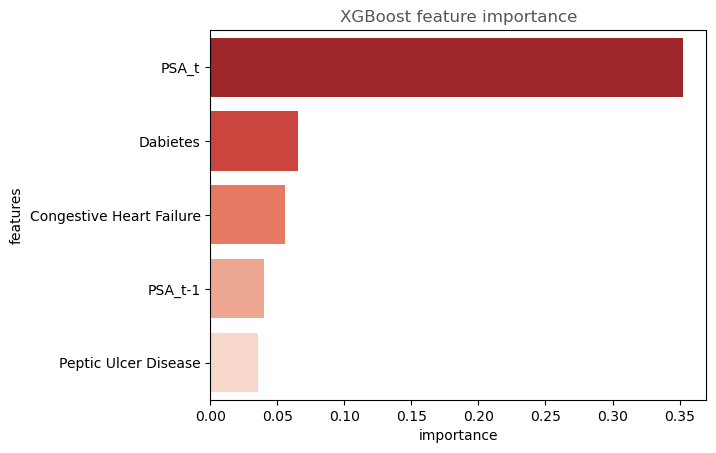

In [42]:
sns.barplot(x = feat_df.importance, y = feat_df.features, palette="Reds_r")
plt.title("XGBoost feature importance")

In [193]:
#optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_intermediate_values(study)

# Traditional Grid Search with CV

In [66]:
params = { 'max_depth': [3, 4, 5, 8],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 200, 500],
           'colsample_bytree': [0.3, 0.5, 0.8, 1],
           'lambda': [0, 1, 10, 50],
           'alpha': [0, 1, 10, 50]}

xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_esti...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    seed=20, subsample=None, tree_method=None,
                                    validate

In [68]:
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
print("RMSE: %.2f" % (mse**(1/2.0)))
print("R2: ", r2_score(y_pred, y_test))
print("MAPE: ", mean_absolute_percentage_error(y_pred, y_test))

RMSE: 4.70
R2:  0.1469799130631685
MAPE:  0.27932872281009996


In [457]:
params = { 'max_depth': [3,4,5, 6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 200, 500],
           'colsample_bytree': [0.3, 0.7],
           'lambda':[1,5,10]}

xgbr = xgb.XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best parameters: {'colsample_bytree': 0.7, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}
Lowest RMSE:  72.97024474180759
